In [1]:
# import the necessary libraries:
import pandas as pd

# Python libraries for visualisation :
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
pio.templates.default = "plotly_white"

# Python libraries for The model :
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


C:\Users\Fatine Boussattine\AppData\Local\Temp\ipykernel_18708\3288295030.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In this forecasting project, we will extensively explore the Plotly library, which is a visualization tool for creating interactive plots in Python.

**Load the Time Series Dataset**

You can access the data and download it via the link : https://statso.io/forecasting-subscriptions-case-study/

In [2]:
df = pd.read_csv('Netflix-Subscriptions.csv')
df

Time Period  Subscribers
0   01/04/2013     34240000
1   01/07/2013     35640000
2   01/10/2013     38010000
3   01/01/2014     41430000
4   01/04/2014     46130000
5   01/07/2014     47990000
6   01/10/2014     50650000
7   01/01/2015     54480000
8   01/04/2015     59620000
9   01/07/2015     62080000
10  01/10/2015     66020000
11  01/01/2016     70840000
12  01/04/2016     77710000
13  01/07/2016     79900000
14  01/10/2016     83280000
15  01/01/2017     89090000
16  01/04/2017     94360000
17  01/07/2017     99040000
18  01/10/2017    104020000
19  01/01/2018    110640000
20  01/04/2018    118900000
21  01/07/2018    124350000
22  01/10/2018    130420000
23  01/01/2019    139260000
24  01/04/2019    148860000
25  01/07/2019    151560000
26  01/10/2019    158330000
27  01/01/2020    167090000
28  01/04/2020    182860000
29  01/07/2020    192950000
30  01/10/2020    195150000
31  01/01/2021    203660000
32  01/04/2021    207640000
33  01/07/2021    209180000
34  01/10/2021    213560000
35  01/01/2022    221840000
36  01/04/2022    221640000
37  01/07/2022    220670000
38  01/10/2022    223090000
39  01/01/2023    230750000
40  01/04/2023    232500000
41  01/07/2023    238390000

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Time Period            42 non-null     datetime64[ns]
 1   Subscribers            42 non-null     int64         
 2   Year                   42 non-null     int32         
 3   Quarterly Growth Rate  41 non-null     float64       
 4   Bar Color              42 non-null     object        
 5   Month                  42 non-null     int32         
 6   Quarter                42 non-null     int32         
 7   Day                    42 non-null     int32         
dtypes: datetime64[ns](1), float64(1), int32(4), int64(1), object(1)
memory usage: 2.1+ KB


It is recommended to convert the 'Time Period' object into a datetime variable

In [4]:
df['Time Period'] = pd.to_datetime(df['Time Period'], format='%d/%m/%Y')
df.head()

Time Period  Subscribers
0  2013-04-01     34240000
1  2013-07-01     35640000
2  2013-10-01     38010000
3  2014-01-01     41430000
4  2014-04-01     46130000

This Time Series Dataset contains subscription counts of Netflix at the start of each quarter from 2013 to 2023.

**Visualisations**

In [5]:
fig = px.line(df, x="Time Period", y="Subscribers", title='Netflix Subscriptions over time')
fig.show()

From this plot, we can see there is a **trend**. But there is **NO seasonality**

In [6]:
df.plot.hist(title='Netflix Subscriptions', figsize=(17, 6))

<Axes: title={'center': 'Netflix Subscriptions'}, ylabel='Frequency'>

Based on the graph, it appears that the distribution is not Gaussian. This observation suggests that the data may not be stationary. 

To confirm the stationarity of the time series, we will split the data by years and calculate the mean for each year. If the mean remains relatively constant across the years, the time series is considered stationary. However, if there are significant variations in the mean values, then the time series is likely non-stationary.

In [7]:

df['Year'] = df['Time Period'].dt.year
df.groupby('Year')['Subscribers'].mean()


Year
2013    3.596333e+07
2014    4.655000e+07
2015    6.055000e+07
2016    7.793250e+07
2017    9.662750e+07
2018    1.210775e+08
2019    1.495025e+08
2020    1.845125e+08
2021    2.085100e+08
2022    2.218100e+08
2023    2.338800e+08
Name: Subscribers, dtype: float64

The mean doesn't remain stable. So, the data isn't stationary.

In [8]:
df['Quarterly Growth Rate'] = df['Subscribers'].pct_change() * 100


# Create a new column for bar color (green for positive growth, red for negative growth)
df['Bar Color'] = df['Quarterly Growth Rate'].apply(lambda x: 'green' if x > 0 else 'red')

# Plot the quarterly growth rate using bar graphs
fig = go.Figure()
fig.add_trace(go.Bar(
    x=df['Time Period'],
    y=df['Quarterly Growth Rate'],
    marker_color=df['Bar Color'],
    name='Quarterly Growth Rate'
))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth Rate',
                  xaxis_title='Time Period',
                  yaxis_title='Quarterly Growth Rate (%)')
fig.show()

Changes over years :

In [9]:
# Calculate the yearly growth rate
df['Year'] = df['Time Period'].dt.year
yearly_growth = df.groupby('Year')['Subscribers'].pct_change().fillna(0) * 100

# Create a new column for bar color (green for positive growth, red for negative growth)
df['Bar Color'] = yearly_growth.apply(lambda x: 'green' if x > 0 else 'red')

# Plot the yearly subscriber growth rate using bar graphs
fig = go.Figure()
fig.add_trace(go.Bar(
    x=df['Year'],
    y=yearly_growth,
    marker_color=df['Bar Color'],
    name='Yearly Growth Rate'
))
fig.update_layout(title='Netflix Yearly Subscriber Growth Rate',
                  xaxis_title='Year',
                  yaxis_title='Yearly Growth Rate (%)')
fig.show()

In [27]:
# Create new features
# Remind that we only want to boxplot quarters and years, because in the TS dataset months aren't all described, besides 'days' that are only the first of each month.
df['Quarter'] = df['Time Period'].dt.quarter

# Boxplots for changes over years and quarters:
fig1 = px.box(df, x= 'Quarter', y='Subscribers')
fig1.update_layout(title='Netflix Subscribers Boxplot by Quarters')
fig1.show()
fig2 = px.box(df, x= 'Year', y='Subscribers')
fig2.update_layout(title='Netflix Subscribers Boxplot by Years')
fig2.show()

So, Netflix subscribers tend to peak over years

# Using ARIMA for Forecasting Netflix Quarterly Subscriptions :

I will start by converting the data into a time series format:

Here we are converting the original DataFrame into a time series format, where the Time Period column becomes the index, and the Subscribers column becomes the data.

In [48]:
# Create a new DataFrame with 'column_name' as the index
new_df = df.set_index('Time Period')
new_df = new_df[['Subscribers']].copy()
new_df.head()

Subscribers
Time Period             
2013-04-01      34240000
2013-07-01      35640000
2013-10-01      38010000
2014-01-01      41430000
2014-04-01      46130000

Now let’s get started with Time Series Forecasting using ARIMA to forecast the number of subscriptions of Netflix using Python.

The ARIMA model has 3 parameters : 
- The order of differencing (d)
- The number of periods in the forecasting period (p) 
- The order of moving average (q)

We find about these parameters with the help of ACF and PACF plots of the differenced time series

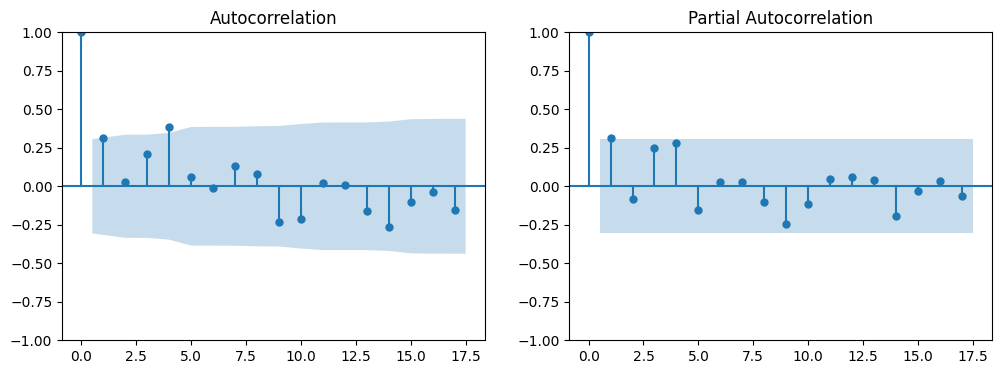

In [71]:
differenced_series = new_df.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

These plots are useful for determining the appropriate parameters when using the ARIMA model for time series forecasting.

So, with ACF plot, q = 1, while the PACF plot also cuts off at lag 1, indicating p=1

As there is a linear trend in the subscription growth rate, we can set the value of d as 1 to remove the linear trend, making the time series stationary.



In [72]:
# Let's use the ARIMA Model !
p, d, q = 1, 1, 1
model = ARIMA(new_df, order=(p, d, q))
arima_model = model.fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:            Subscribers   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -672.993
Date:                Fri, 09 Feb 2024   AIC                           1351.986
Time:                        21:54:01   BIC                           1357.127
Sample:                    04-01-2013   HQIC                          1353.858
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.012     80.769      0.000       0.975       1.024
ma.L1         -0.9908      0.221     -4.476      0.000      -1.425      -0.557
sigma2      1.187e+13   1.57e-14   7.57e+26      0.0

c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



Let's make predictions for the next 5 quarters !

In [19]:
new_df.tail()

Subscribers
Time Period             
01/07/2022     220670000
01/10/2022     223090000
01/01/2023     230750000
01/04/2023     232500000
01/07/2023     238390000

In [88]:
len(new_df)

42

In [87]:
# Let's fix the issue with the future indexes :
future_steps = 5
predictions = arima_model.predict(len(new_df), len(new_df) + future_steps - 1)
predictions = predictions.astype(int)
predictions

2023-10-01    243321465
2024-01-01    248251663
2024-04-01    253180592
2024-07-01    258108254
2024-10-01    263034649
Freq: QS-OCT, Name: predicted_mean, dtype: int32

Now let’s visualize the results of Netflix Subscriptions Forecasting for the next five quarters:

In [82]:
# Create a DataFrame with the original data and predictions
time_series = df.set_index('Time Period')['Subscribers']
forecast = pd.DataFrame({'Original': time_series, 'Predictions': predictions})

# Plot the original data and predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Predictions'],
                         mode='lines', name='Predictions'))

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Original'],
                         mode='lines', name='Original Data'))

fig.update_layout(title='Netflix Quarterly Subscription Predictions',
                  xaxis_title='Time Period',
                  yaxis_title='Subscribers',
                  legend=dict(x=0.1, y=0.9),
                  showlegend=True)

fig.show()

In [83]:
len(new_df)

42

In [80]:
arima_model.predict(41, 46)

2023-07-01    2.374114e+08
2023-10-01    2.433215e+08
2024-01-01    2.482517e+08
2024-04-01    2.531806e+08
2024-07-01    2.581083e+08
2024-10-01    2.630346e+08
Freq: QS-OCT, Name: predicted_mean, dtype: float64

In [ ]:
'This is another method to make forecasting into the future : arima_model.get_forecast(steps=5).predicted_mean'
future_steps = 5

# Use the predict method
predictions = arima_model.get_forecast(steps=future_steps)

# Access the predicted values
predicted_values = predictions.predicted_mean.astype(int)